In [28]:
# import packages
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [29]:
path_inception = f"./datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()


349[0][0]             
__________________________________________________________________________________________________
conv2d_351 (Conv2D)             (None, 7, 7, 192)    147456      average_pooling2d_33[0][0]       
__________________________________________________________________________________________________
batch_normalization_342 (BatchN (None, 7, 7, 192)    576         conv2d_342[0][0]                 
__________________________________________________________________________________________________
batch_normalization_345 (BatchN (None, 7, 7, 192)    576         conv2d_345[0][0]                 
__________________________________________________________________________________________________
batch_normalization_350 (BatchN (None, 7, 7, 192)    576         conv2d_350[0][0]                 
__________________________________________________________________________________________________
batch_normalization_351 (BatchN (None, 7, 7, 192)    576         conv2d_351[0][0]     

In [30]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [31]:
# load data here 
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [32]:
# split the images into train and test 
from os import walk
flower_photos = '/Users/prashunjaveri/.keras/datasets/flower_photos/'
_, _, filenames = next(walk(flower_photos))
root_dir = '../../tensorflow_datasets/flower_photos'
os.mkdir(root_dir)
training_dir_path = os.path.join(root_dir,'training')
os.mkdir(training_dir_path)
validation_dir_path = os.path.join(root_dir,'validation')
os.mkdir(validation_dir_path)

In [33]:
folders = _ 
for folder in folders:
    training_folder = os.path.join(training_dir_path,folder)
    os.mkdir(training_folder)
    validation_folder = os.path.join(validation_dir_path,folder)
    os.mkdir(validation_folder)

In [34]:
folders = _
for folder in folders:
    current_training_folder=os.path.join(training_dir_path,folder)
    current_validation_folder=os.path.join(validation_dir_path,folder)
    root_path=os.path.join(flower_photos,folder)
    image_list=list(os.listdir(root_path))
    total_no_of_images=len(image_list)
    no_of_images_in_traing_set=int(total_no_of_images*(1-0.2))
    no_of_images_in_validation_set=int(total_no_of_images*0.2)
    validation_list=image_list[:no_of_images_in_validation_set]
    training_list=image_list[:no_of_images_in_traing_set]
    for item in training_list:
        dest_path=os.path.join(current_training_folder,item)
        src_path=os.path.join(root_path,item)
        copyfile(src_path, dest_path)
    for item in validation_list:
        dest_path=os.path.join(current_validation_folder,item)
        src_path=os.path.join(root_path,item)
        copyfile(src_path, dest_path)
    

/Users/prashunjaveri/.keras/datasets/flower_photos/roses/16209331331_343c899d38.jpg


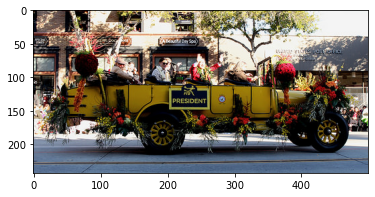

In [35]:
from PIL import Image
import numpy as np
from skimage import transform
from scipy import ndimage
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

roses = list(data_dir.glob('roses/*'))
print(roses[0])

img = mpimg.imread(roses[0])
imgplot = plt.imshow(img)
plt.show()

In [36]:
callbacks = tf.keras.callbacks.Callback

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [37]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory('../../tensorflow_datasets/flower_photos/training/',
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( '../../tensorflow_datasets/flower_photos/validation/',
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))


Found 2934 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [38]:

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)          

model = Model( pre_trained_model.input, x) 

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# fit the model 
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            steps_per_epoch=20,
            epochs=4,
            validation_steps=5,
            callbacks=[myCallback()],
            verbose=2)
            

Epoch 1/4
20/20 - 22s - loss: 4.7836 - accuracy: 0.4225 - val_loss: 1.2093 - val_accuracy: 0.6100
Epoch 2/4
20/20 - 17s - loss: 1.1126 - accuracy: 0.6850 - val_loss: 1.1596 - val_accuracy: 0.6500
Epoch 3/4
20/20 - 16s - loss: 0.8268 - accuracy: 0.7350 - val_loss: 0.5598 - val_accuracy: 0.7800
Epoch 4/4
20/20 - 18s - loss: 0.7531 - accuracy: 0.7475 - val_loss: 0.7552 - val_accuracy: 0.7400


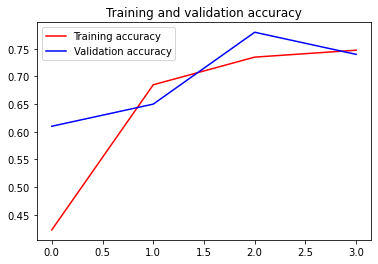

<Figure size 432x288 with 0 Axes>

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [40]:
model.summary()

              
__________________________________________________________________________________________________
activation_327 (Activation)     (None, 7, 7, 160)    0           batch_normalization_327[0][0]    
__________________________________________________________________________________________________
conv2d_323 (Conv2D)             (None, 7, 7, 160)    122880      mixed4[0][0]                     
__________________________________________________________________________________________________
conv2d_328 (Conv2D)             (None, 7, 7, 160)    179200      activation_327[0][0]             
__________________________________________________________________________________________________
batch_normalization_323 (BatchN (None, 7, 7, 160)    480         conv2d_323[0][0]                 
__________________________________________________________________________________________________
batch_normalization_328 (BatchN (None, 7, 7, 160)    480         conv2d_328[0][0]             

In [41]:
validation_generator.reset()
pred=model.predict(validation_generator,
steps=10,
verbose=1)

filenames = validation_generator.filenames
nb_samples = len(filenames)

print(nb_samples)
print(filenames[1])


10/10 [==============================] - 7s 574ms/step
731
daisy/10555815624_dc211569b0.jpg


In [42]:
predictions = []
for p in  pred:
    predictions.append(np.argmax(p))

label = predictions[1]
class_names =['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print(class_names[label])


roses


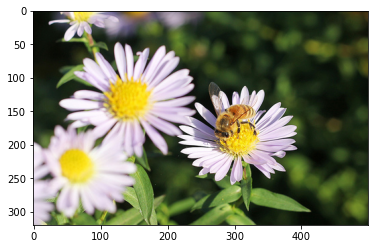

In [43]:
path =os.path.join(flower_photos,filenames[1])
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()